## Import Libraries and Configuration

In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# --- Configuration ---
DATASET_DIR = "../Rust_Dataset"
IMG_HEIGHT, IMG_WIDTH = 640, 640
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 4
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

## Helper Functions

In [4]:
def calculate_code_metrics():
    """Calculates code complexity metrics using 'radon'."""
    try:
        import radon.complexity as cc
        import radon.metrics as mi
        # For notebook, we'll skip file reading and return placeholder values
        return 0, 0
    except ImportError:
        print("[WARN] 'radon' not installed. Skipping Functionality & Compatibility metrics.")
        return 0, 0

In [5]:
def calculate_map(model, dataloader, device):
    """Calculates Mean Average Precision using 'scikit-learn'."""
    try:
        from sklearn.metrics import average_precision_score
        from sklearn.preprocessing import label_binarize
        
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                outputs = torch.softmax(model(inputs), dim=1)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.numpy())
        
        y_pred_probs = np.concatenate(all_preds)
        y_true = np.concatenate(all_labels)
        y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
        return average_precision_score(y_true_bin, y_pred_probs, average="macro")
    except ImportError:
        print("[WARN] 'scikit-learn' not installed. Skipping Performance (mAP) metric.")
        return 0.0

## Check Device

In [6]:
print(f"--- Starting MobileNetV3-Small Training & Analysis ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

--- Starting MobileNetV3-Small Training & Analysis ---
Using device: cuda


## Data Preparation

In [7]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
}

In [8]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_DIR, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
               for x in ['train', 'valid']}

test_loader = DataLoader(image_datasets['test'], batch_size=1, shuffle=False, num_workers=0)

print(f"Data loaded. Train images: {len(image_datasets['train'])}")

Data loaded. Train images: 438


In [9]:
# Print tensor sizes
sample_input, _ = next(iter(dataloaders['train']))
print(f"Sample input tensor size: {sample_input.size()}")

Sample input tensor size: torch.Size([16, 3, 640, 640])


## Model Setup

In [10]:
# Model Construction (MobileNetV3 Small)
# "Small" version is optimized for low-power/high-speed usage
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False
    
# Classifier structure is model.classifier[3] for V3
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, NUM_CLASSES)

model = model.to(device)
print("Model loaded and configured!")

Model loaded and configured!


In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

## Training Loop

In [12]:
print("Training model...")

# Lists to store training history
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(image_datasets['train'])
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_valid_loss = running_loss / len(image_datasets['valid'])
    epoch_valid_acc = correct / total
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.4f}")

Training model...
Epoch 1/30 - Train Loss: 1.3428, Train Acc: 0.3607, Valid Loss: 1.3378, Valid Acc: 0.3821
Epoch 1/30 - Train Loss: 1.3428, Train Acc: 0.3607, Valid Loss: 1.3378, Valid Acc: 0.3821
Epoch 2/30 - Train Loss: 1.2464, Train Acc: 0.5183, Valid Loss: 1.2653, Valid Acc: 0.5122
Epoch 2/30 - Train Loss: 1.2464, Train Acc: 0.5183, Valid Loss: 1.2653, Valid Acc: 0.5122
Epoch 3/30 - Train Loss: 1.1610, Train Acc: 0.5845, Valid Loss: 1.1879, Valid Acc: 0.5854
Epoch 3/30 - Train Loss: 1.1610, Train Acc: 0.5845, Valid Loss: 1.1879, Valid Acc: 0.5854
Epoch 4/30 - Train Loss: 1.0739, Train Acc: 0.6872, Valid Loss: 1.1090, Valid Acc: 0.6179
Epoch 4/30 - Train Loss: 1.0739, Train Acc: 0.6872, Valid Loss: 1.1090, Valid Acc: 0.6179
Epoch 5/30 - Train Loss: 1.0304, Train Acc: 0.7032, Valid Loss: 1.0382, Valid Acc: 0.6504
Epoch 5/30 - Train Loss: 1.0304, Train Acc: 0.7032, Valid Loss: 1.0382, Valid Acc: 0.6504
Epoch 6/30 - Train Loss: 0.9662, Train Acc: 0.7100, Valid Loss: 0.9789, Valid Acc:

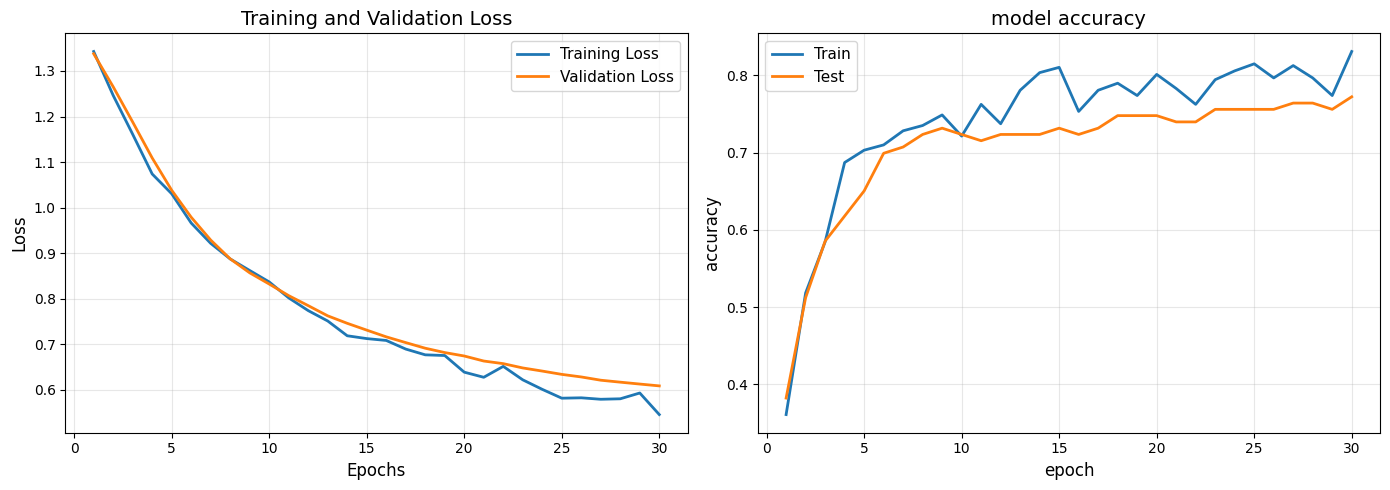


Final Train Loss: 0.5457 - Train Accuracy: 0.8311
Final Valid Loss: 0.6087 - Valid Accuracy: 0.7724


In [13]:
# Visualize training history with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss over epochs
epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, train_losses, linewidth=2, label='Training Loss', color='#1f77b4')
ax1.plot(epochs_range, valid_losses, linewidth=2, label='Validation Loss', color='#ff7f0e')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Accuracy over epochs
ax2.plot(epochs_range, train_accs, linewidth=2, label='Train', color='#1f77b4')
ax2.plot(epochs_range, valid_accs, linewidth=2, label='Test', color='#ff7f0e')
ax2.set_xlabel('epoch', fontsize=12)
ax2.set_ylabel('accuracy', fontsize=12)
ax2.set_title('model accuracy', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Valid Loss: {valid_losses[-1]:.4f} - Valid Accuracy: {valid_accs[-1]:.4f}")

## Metrics Calculation

In [14]:
print("\n--- Calculating Metrics ---")

total_params = sum(p.numel() for p in model.parameters())

model.eval()
start_time = time.time()
steps_to_test = 50
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        if i >= steps_to_test: break
        inputs = inputs.to(device)
        _ = model(inputs)
end_time = time.time()
avg_inference_time_ms = ((end_time - start_time) / steps_to_test) * 1000

mAP = calculate_map(model, test_loader, device)
avg_cc, maint_index = calculate_code_metrics()


--- Calculating Metrics ---


## Results Report

In [15]:
print("\n" + "="*50)
print("RUST DETECTION MODEL: MOBILENETV3-SMALL REPORT")
print("="*50)
print(f"1. Manufacturability (Model Complexity): {total_params:,} parameters")
print(f"2. Efficiency (Avg Inference Time):      {avg_inference_time_ms:.2f} ms/image")
print(f"3. Performance (Mean Average Precision): {mAP:.4f}")
print(f"4. Functionality (Cyclomatic Complexity):{avg_cc:.2f} (Avg per block)")
print(f"5. Compatibility (Maintainability Index):{maint_index:.2f} (Scale 0-100)")
print("="*50)


RUST DETECTION MODEL: MOBILENETV3-SMALL REPORT
1. Manufacturability (Model Complexity): 1,521,956 parameters
2. Efficiency (Avg Inference Time):      9.55 ms/image
3. Performance (Mean Average Precision): 0.9197
4. Functionality (Cyclomatic Complexity):0.00 (Avg per block)
5. Compatibility (Maintainability Index):0.00 (Scale 0-100)


## Save Model

In [16]:
torch.save(model.state_dict(), 'rust_mobilenetv3_small.pth')
print("Model saved to rust_mobilenetv3_small.pth")

Model saved to rust_mobilenetv3_small.pth
